<div style='display:flex;flex-direction:column; text-align :center; padding:25px; border:solid; gap:50px'>
    <div style=''>
        <div style='font-size:23px; font-weight:bold; margin-bottom:20px'>CAPSTONE MODULE 3</div>
        <div style='font-size:28px; font-weight:bold'>E-COMMERCE CUSTOMER CHURN</div>
        <div style='font-size:25px; font-weight:bold'>Analysis and Prediction</div>
    </div>
    <div style='display:flex; flex-direction:column; text-align :center; gap:10px' >
        <div style='font-size:18px;'>Ahmad Fiqri Oemry</div>
        <div style='font-size:18px; '>DTI DS 0106</div>
    </div>
</div>

In [5]:
# Basic Libraries
import pandas as pd
import numpy as np


# Data Visualization
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt


# Data Statistical Test
from scipy.stats import normaltest
from scipy.stats import chi2_contingency


# Data Preprocessing
from scipy.stats import uniform
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import  OrdinalEncoder, OneHotEncoder, RobustScaler, MinMaxScaler


# Data Modeling
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV


# Evaluation Metrics
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix

# explain AI
import shap

# Deployment
import pickle

import warnings
warnings.filterwarnings('ignore')

In [6]:
# importing dataset use for building a model
df_raw = pd.read_csv('./data/ecommerce_customer_churn_data_raw.csv')

In [7]:
df_raw['PreferedOrderCat'] = df_raw['PreferedOrderCat'].replace('Mobile', 'Mobile Phone')

In [8]:
# removing duplicated values
df_raw.drop_duplicates(inplace=True)

<div id='#business-problem' style="font-size: 20px; font-weight: bold;">4.1.4 Save Clean Data</div>


In [9]:
# # Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Columns to impute
columns_to_impute = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']


# # input the missing value using knn method
df_raw[columns_to_impute] = knn_imputer.fit_transform(df_raw[columns_to_impute])

In [10]:
df_raw.drop(df_raw[df_raw['Tenure'] > 37].index,inplace=True)
df_raw.drop(df_raw[df_raw['WarehouseToHome'] > 36.5 ].index,inplace=True)

In [11]:
df = df_raw.copy()

In [12]:
df['Churn'].value_counts()

Churn
0    2731
1     533
Name: count, dtype: int64

In [13]:
# Define X and Y
X = df.drop(columns=['Churn'])
y = df['Churn']

# define static random state for model clasification
RANDOM_STATE = 42

# Split the dataset between test and train with size 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state = RANDOM_STATE)

In [14]:
feature_impute_scaling = Pipeline([
    ('KNN Imputer', knn_imputer),
    ('robust', RobustScaler()),
])

In [15]:
# Membuat kolom Transformasi
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['MaritalStatus','PreferedOrderCat']),
    ('Impute & Robust Scale', feature_impute_scaling, ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore', 'Complain']),
])

transformer

ColumnTransformer(transformers=[('onehot', OneHotEncoder(drop='first'),
                                 ['MaritalStatus', 'PreferedOrderCat']),
                                ('Impute & Robust Scale',
                                 Pipeline(steps=[('KNN Imputer', KNNImputer()),
                                                 ('robust', RobustScaler())]),
                                 ['Tenure', 'WarehouseToHome',
                                  'NumberOfDeviceRegistered', 'NumberOfAddress',
                                  'DaySinceLastOrder', 'CashbackAmount',
                                  'SatisfactionScore', 'Complain'])])

In [16]:
# Calculate the scale_pos_weight for imbalance dataset for model classification XGboost
num_negatives = np.sum(y_train == 0)
num_positives = np.sum(y_train == 1)
scale_pos_weight = num_negatives / num_positives

In [17]:
# define all model classification for benchmark testing
lgbm = lgb.LGBMClassifier(objective='binary', random_state = RANDOM_STATE, verbose= -1)
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state = RANDOM_STATE, verbosity = 0)

In [18]:
skfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state = RANDOM_STATE)

In [19]:
hyperparam_space = {
    'model__boosting_type': ['gbdt', 'dart', 'goss'],
    'model__max_depth': list(np.arange(1, 31)),
    'model__num_leaves': list(np.arange(2, 900, 5)),
    'model__min_data_in_leaf': list(np.arange(10, 101, 2)),
    'model__num_iterations': list(np.arange(10, 101, 2)),
    'model__learning_rate': uniform(0.01, 0.99),
    'model__subsample': uniform(0.5, 0.5),  # Range from 0.5 to 1.0
    'model__colsample_bytree': uniform(0.5, 0.5),  # Range from 0.5 to 1.0
    'model__reg_alpha': uniform(0, 1),  # L1 regularization
    'model__reg_lambda': uniform(0, 1)  # L2 regularization
}

In [20]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
hyperparameter_space = {
    'model__booster': ['gbtree', 'gblinear', 'dart'],
    'model__learning_rate': uniform(0.01, 0.3),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight': randint(1, 10),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.3, 0.7),
    'model__reg_lambda': uniform(0, 2),
    'model__reg_alpha': uniform(0, 2),
    'model__gamma': uniform(0, 2),
    'model__n_estimators': randint(50, 200)
}

In [21]:
smote = SMOTE(random_state = RANDOM_STATE)
adasyn = ADASYN(random_state = RANDOM_STATE)
svm_smote = SVMSMOTE(random_state = RANDOM_STATE)
borderline_smote = BorderlineSMOTE(random_state = RANDOM_STATE)
ros = RandomOverSampler(random_state = RANDOM_STATE, sampling_strategy= 'minority')
rus = RandomUnderSampler(random_state = RANDOM_STATE, sampling_strategy = 'majority')
smote_enn = SMOTEENN(smote=SMOTE(random_state = RANDOM_STATE), enn=EditedNearestNeighbours())

In [22]:
# # Define your resampling techniques
# best_resamples = [
#     ('ROS', ros),
#     ('SMOTEENN', smote_enn),
#     ('SMOTE_SVN', svm_smote),
#     ('SMOTE', smote),  
# ]

# # Initialize lists to store results
# resampling_names = []
# xgb_tuning_train_score = []
# xgb_tuning_test_score_before = []
# xgb_tuning_test_score_after = [] 
# xgb_tuning_train_score_diff_with_tuning = []
# xgb_tuning_test_score_diff_before_after_tuning = []

# # Loop through each resampling method and each model
# for name, resample in best_resamples:
#     # Model pipeline without hyperparameter tuning
#     model_pipeline_before_tuning = ImbPipeline([
#         ('transformer', transformer),
#         ('resampling', resample),
#         ('model', xgb)
#     ])
    
#     # Fit the model pipeline without tuning
#     model_pipeline_before_tuning.fit(X_train, y_train)
#     # Predict on the test set before tuning
#     y_pred_test_before = model_pipeline_before_tuning.predict(X_test)
#     # Calculate F2 score before tuning
#     f2_score_test_before = fbeta_score(y_test, y_pred_test_before, beta=2)
    
    
#     # Initialize RandomizedSearchCV for hyperparameter tuning
#     random_search = RandomizedSearchCV(
#         estimator=model_pipeline_before_tuning, 
#         param_distributions=hyperparam_space, 
#         n_jobs=-1,
#         n_iter=50, 
#         scoring=make_scorer(fbeta_score, beta=2), 
#         cv=skfold, 
#         random_state=RANDOM_STATE
#     )
    
#     # Fit RandomizedSearchCV for hyperparameter tuning
#     random_search.fit(X_train, y_train)
    
#     # Get the best estimator from RandomizedSearchCV
#     best_model = random_search.best_estimator_
    
#     # Predicting on the training set
#     y_pred_train = best_model.predict(X_train)
    
#     # Predicting on the test set after tuning
#     y_pred_test_after = best_model.predict(X_test)
    
#     # Evaluate the scores
#     f2_score_train = fbeta_score(y_train, y_pred_train, beta=2)
#     f2_score_test_after = fbeta_score(y_test, y_pred_test_after, beta=2)
    
#     # Calculate the score differences
#     train_score_diff_with_tuning = f2_score_train - f2_score_test_after
    
#     # Append results to lists
#     resampling_names.append(name)
#     xgb_tuning_train_score.append(f2_score_train)
#     xgb_tuning_test_score_before.append(f2_score_test_before)
#     xgb_tuning_test_score_after.append(f2_score_test_after)
#     xgb_tuning_train_score_diff_with_tuning.append(train_score_diff_with_tuning)

In [23]:
# # Create a DataFrame to display the results
# best_tuning_method_xgb = pd.DataFrame({
#     'resampling name': resampling_names,
#     'train_score': xgb_tuning_train_score,
#     'test_score_before_tuning': xgb_tuning_test_score_before,
#     'test_score_after_tuning': xgb_tuning_test_score_after,
#     'train_score_diff_with_tuning': xgb_tuning_train_score_diff_with_tuning,
# }).sort_values(by='test_score_after_tuning', ascending=False)

# best_tuning_method_xgb

In [24]:
best_model_pipe_xgb = ImbPipeline([
    ('preprocess', transformer),
    ('resampling', smote_enn),
    ('model', xgb)
])

# Define the RandomizedSearchCV
best_random_xgb = RandomizedSearchCV(
    estimator=best_model_pipe_xgb,
    param_distributions=hyperparam_space,
    cv=skfold,
    scoring= make_scorer(fbeta_score, beta=2),
    n_jobs=-1,
    n_iter=50,
    random_state=RANDOM_STATE,
)

# Fit the RandomizedSearchCV
best_random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['MaritalStatus',
                                                                                'PreferedOrderCat']),
                                                                              ('Impute '
                                                                               '& '
                                                                               'Robust '
                                                                               'Scale',
                                                                               Pipeline(steps=[('KNN '
                                                                                                'Imputer',
                                                                                                KNNImputer()),
                                                                                               ('robust',
                                                                                                RobustScaler())]),
                                                                               ['Tenure',
                                                                                'Warehouse...
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000200C6B32540>,
                                        'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000200C6B337D0>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000200C6845E80>},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [28]:
best_model = best_random_xgb.best_estimator_

# Test score before tuned
best_model_pipe_xgb.fit(X_train, y_train)
y_pred_default = best_model_pipe_xgb.predict(X_test)
f2_default = fbeta_score(y_test, y_pred_default, beta=2)

# Predict on training set
y_train_pred_tuned = best_model.predict(X_train)
f2_train = fbeta_score(y_train, y_train_pred_tuned, beta=2)

# Predict on test set
y_test_pred_tuned = best_model.predict(X_test)
f2_test = fbeta_score(y_test, y_test_pred_tuned, beta=2)

print(f2_default)
print(f2_train)
print(f2_test)

0.7904411764705882
0.9094942324755989
0.8620689655172413


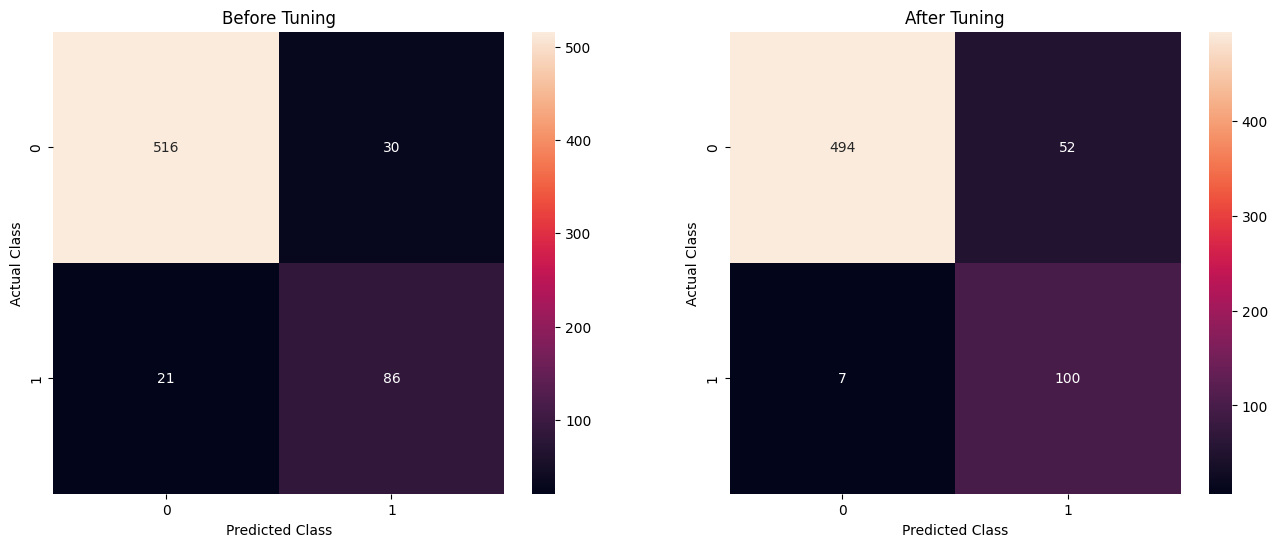

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, y_pred_default), annot=True, fmt='g').set_title('Before Tuning')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_test_pred_tuned), annot=True, fmt='g').set_title('After Tuning')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class');

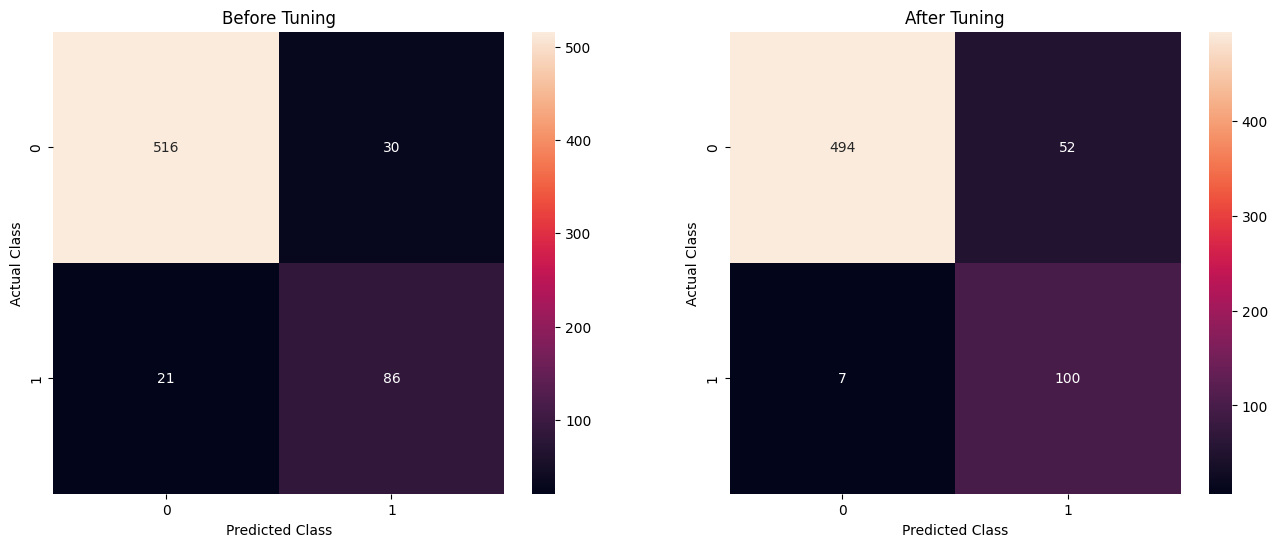

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, y_pred_default), annot=True, fmt='g').set_title('Before Tuning')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_test_pred_tuned), annot=True, fmt='g').set_title('After Tuning')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class');